In [ ]:
import numpy as np
import numpy.linalg
import pandas as pd
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics, sklearn.decomposition
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD 
from sklearn.decomposition import NMF
from pathlib import Path

# Dimensionality Reduction and Matrix Factorization

## Objectives:
1. Apply SVD (complete) and Reduced SVD method to Bars Dataset and evaluate also data with noise.
2. Reconstruct the data with different reduction (2, 5, 10, 16 basis functions).
3. Try the NNMF method similarly.
4. Take the Mnist dataset and apply SVD recomposition and visualize it in vector space. Coloring take from Labels
5. Try to reconstruct the reduced data and visualize it.
6. Use PCA and t-SNE for further visualization of the Mnist dataset

---


## Exercise 1: Bars Dataset - SVD Analysis

**Task:** Apply SVD decomposition to the bars dataset.

- Apply complete SVD decomposition to noisy and clean data
- Visualize the singular values and compare clean vs noisy data
- Analyze the differences in singular value patterns


In [ ]:
def load_bars_csv(path: str):
    df = pd.read_csv(path, header=None)
    X = df.values.astype(float)
    side = int(np.sqrt(X.shape[1])) 
    img_shape = (side, side) if side * side == X.shape[1] else None
    return X, img_shape

paths = {
    "clean": "datasets/ml_05/bars.csv",
    "noise20": "datasets/ml_05/bars_noise20.csv",
    "noise50": "datasets/ml_05/bars_noise50.csv",
}

datasets = {}
for name, path in paths.items():
    X, img_shape = load_bars_csv(path)
    Xc = X - X.mean(axis=0, keepdims=True)  # centrovani dat (odecteni prumeru od kazdeho sloupce, aby vznikly rozdily)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False) # SVD rozdeli vsechny obrazky na par zakladnich tvaru, seradi je podle dulezitosti a z mala jejich kombinaci slozi puvodni obrazky
    datasets[name] = {
        # X - puvodni data
        # Xc - centrovana data
        # U - recept, kolik kterho tvaru (komponenty) je v kazdem obrazku
        # S - jak dulezity je kazdy tvar (vetsi = dulezitejsi)
        # Vt - zakladni tvary (male pruhy)
        # img_shape - tvar obrazku (pro vizualizaci)
        "X": X, "Xc": Xc, "U": U, "S": S, "Vt": Vt, "img_shape": img_shape
    }
# n_samples = pocet obrazku, n_features = pocet pixelu v kazdem obrazku
print("Shapes (n_samples, n_features):", {k: v["X"].shape for k, v in datasets.items()})

Shapes (n_samples, n_features): {'clean': (10000, 64), 'noise20': (10000, 64), 'noise50': (10000, 64)}


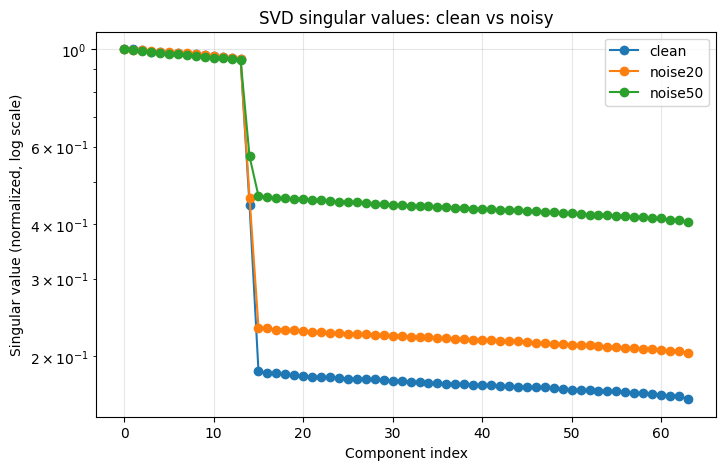

In [ ]:
plt.figure(figsize=(8,5))
for name, d in datasets.items():
    S = d["S"]
    plt.semilogy(S / S[0], marker='o', label=name)
plt.xlabel("Index komponenty") # komponenty jsou serazeny podle dulezitosti
plt.ylabel("Velikost singularni hodnoty (normalizovana)")
plt.title("SVD singular values: clean vs noisy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# Hledame, kolik komponent je potreba k reprezentaci dat s urcitym
# V tomto grafu vidime ze 16 komponent staci k reprezentaci cistych dat (clean)
# Clean - ostry zlom
# Noise20 - zlom je pozvolnejsi - vice energie je rozptyleno do vic komponent
# Noise50 - zlom je mene vyzrazny - jeste vice energie je rozptyleno do vic komponent

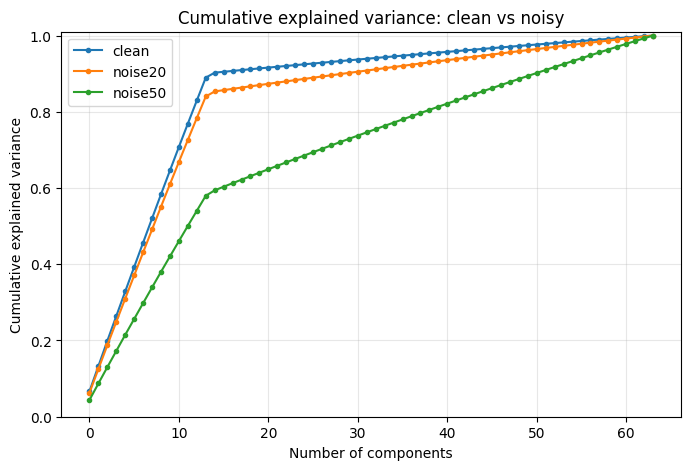

In [ ]:
plt.figure(figsize=(8,5))
for name, d in datasets.items():
    S = d["S"]
    evr = (S**2) / np.sum(S**2)
    plt.plot(np.cumsum(evr), marker='.', label=name)
plt.xlabel("Pocet komponent K")
plt.ylabel("Kolik variance pokryvaji prvni K komponent")
plt.title("Cumulative explained variance: clean vs noisy")
plt.ylim(0, 1.01)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# Vidime, ze pro cista data staci kolem 16 komponent k pokryti skoro cele variance


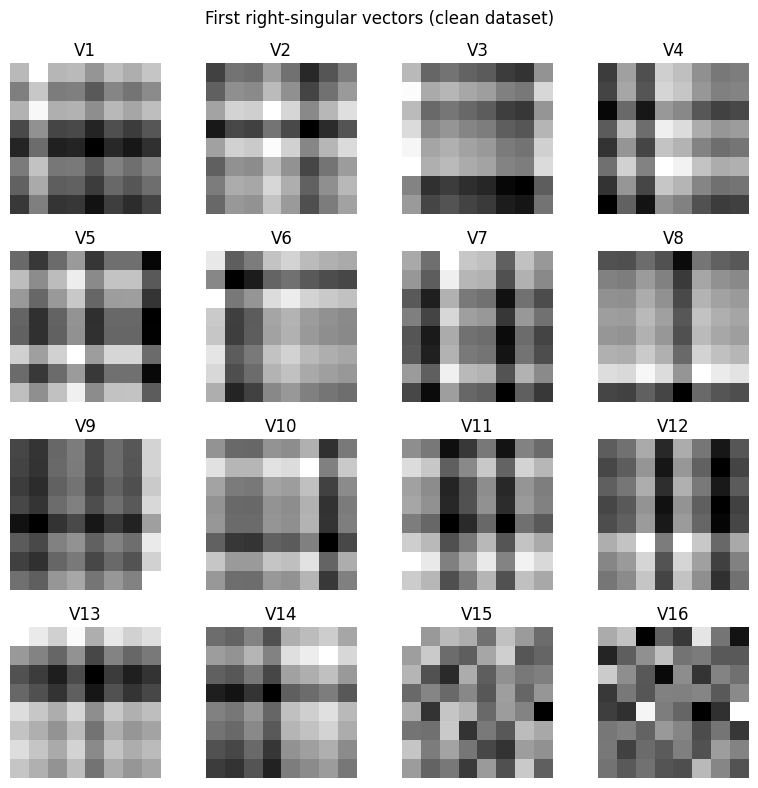

In [5]:
img_shape = datasets["clean"]["img_shape"]
if img_shape is not None:
    Vt = datasets["clean"]["Vt"]
    k = min(16, Vt.shape[0])
    rows = int(np.ceil(k/4))
    fig, axes = plt.subplots(rows, 4, figsize=(8, 2*rows))
    axes = np.atleast_2d(axes).ravel()
    for i in range(k):
        axes[i].imshow(Vt[i].reshape(img_shape), cmap="gray")
        axes[i].set_title(f"V{i+1}")
        axes[i].axis("off")
    for j in range(k, len(axes)):
        axes[j].axis("off")
    fig.suptitle("First right-singular vectors (clean dataset)")
    plt.tight_layout()
    plt.show()
else:
    print("Feature count is not a perfect square; skipping basis image visualization.")

In [8]:
ks = [2, 5, 10, 16]
print("\nReduced SVD (TruncatedSVD) cumulative explained variance:")
for name, d in datasets.items():
    Xc = d["Xc"]
    max_k = min(Xc.shape)  # cannot exceed rank
    summary = {}
    for k in ks:
        k_eff = min(k, max_k)
        tsvd = TruncatedSVD(n_components=k_eff, random_state=0)
        tsvd.fit(Xc)
        summary[k_eff] = float(np.cumsum(tsvd.explained_variance_ratio_)[-1])
    print(f"{name}: {summary}")


Reduced SVD (TruncatedSVD) cumulative explained variance:
clean: {2: 0.13252847239379656, 5: 0.3287569146220972, 10: 0.6461168096839808, 16: 0.9047927206886175}
noise20: {2: 0.12497173536285913, 5: 0.3099694448469291, 10: 0.6102474122481005, 16: 0.8566591452926366}
noise50: {2: 0.08703915465103301, 5: 0.214891900942519, 10: 0.42066467856755235, 16: 0.6031229887950785}


## Exercise 2: Data Reconstruction with Different Reduction Levels

**Task:** Reconstruct the Bars Dataset using different numbers of basis functions.

- Test reconstruction with 2, 5, 10, and 16 basis functions
- Calculate reconstruction error (MSE) for each reduction level
- Visualize original vs reconstructed data
- Plot reconstruction error vs number of components



Reconstruction MSE (nižší je lepší) a EVR (vyšší je lepší)

clean    k= 2  MSE=13673.612856  EVR=0.133
clean    k= 5  MSE=10585.692737  EVR=0.329
clean    k=10  MSE=5580.837701  EVR=0.646
clean    k=16  MSE=1499.712618  EVR=0.905

noise20  k= 2  MSE=10513.273603  EVR=0.125
noise20  k= 5  MSE=8293.270317  EVR=0.310
noise20  k=10  MSE=4684.319474  EVR=0.610
noise20  k=16  MSE=1721.575378  EVR=0.857

noise50  k= 2  MSE=9902.916218  EVR=0.087
noise50  k= 5  MSE=8517.660702  EVR=0.215
noise50  k=10  MSE=6285.226103  EVR=0.421
noise50  k=16  MSE=4303.402819  EVR=0.603



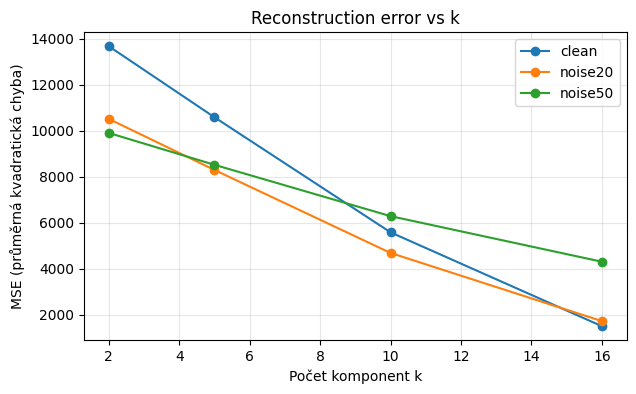

In [10]:
def reconstruct_rank_k(d, k: int):
    X, U, S, Vt = d["X"], d["U"], d["S"], d["Vt"]
    k_eff = min(k, len(S))
    Xc_hat = (U[:, :k_eff] * S[:k_eff]) @ Vt[:k_eff, :]
    return Xc_hat + X.mean(axis=0, keepdims=True)  # zpět přičteme průměr

def mse(a, b):
    return float(np.mean((a - b)**2))

ks = [2, 5, 10, 16]
print("Reconstruction MSE (nižší je lepší) a EVR (vyšší je lepší)\n")
errors = {name: {} for name in datasets}

for name, d in datasets.items():
    X = d["X"]
    S = d["S"]
    evr_full = (S**2) / (S**2).sum()
    for k in ks:
        X_hat = reconstruct_rank_k(d, k)
        errors[name][k] = mse(X, X_hat)
        evr_k = evr_full[:min(k, len(S))].sum()
        print(f"{name:8s} k={k:2d}  MSE={errors[name][k]:.6f}  EVR={evr_k:.3f}")
    print()

# Graf MSE vs k
plt.figure(figsize=(7,4))
for name in datasets:
    xs = []
    ys = []
    for k in ks:
        xs.append(k)
        ys.append(errors[name][k])
    plt.plot(xs, ys, marker="o", label=name)
plt.xlabel("Počet komponent k")
plt.ylabel("MSE (průměrná kvadratická chyba)")
plt.title("Reconstruction error vs k")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

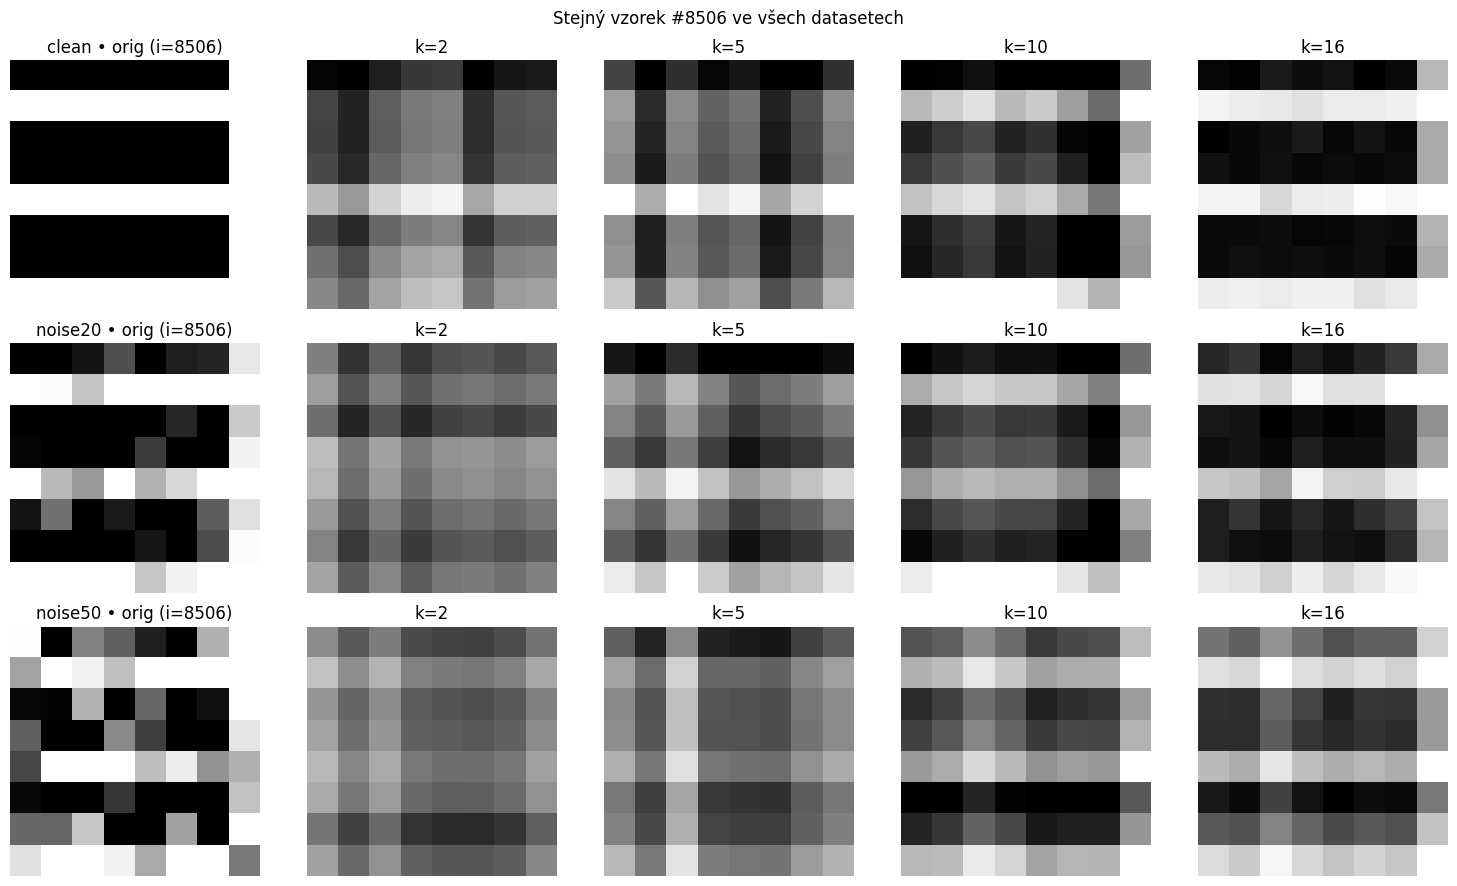

In [13]:
# Jedna figura: stejný vzorek napříč datasety
rng = np.random.default_rng(0)
ks = [2, 5, 10, 16]
names = list(datasets.keys())

min_n = min(datasets[n]["X"].shape[0] for n in names)
i = int(rng.integers(0, min_n))

rows, cols = len(names), 1 + len(ks)
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
for r, name in enumerate(names):
    d = datasets[name]
    img_shape = d["img_shape"]
    X = d["X"]
    vmin, vmax = X.min(), X.max()

    axes[r, 0].imshow(X[i].reshape(img_shape), cmap="gray", vmin=vmin, vmax=vmax)
    axes[r, 0].set_title(f"{name} • orig (i={i})")
    axes[r, 0].axis("off")

    for c, k in enumerate(ks, start=1):
        X_hat = reconstruct_rank_k(d, k)
        axes[r, c].imshow(X_hat[i].reshape(img_shape), cmap="gray", vmin=vmin, vmax=vmax)
        axes[r, c].set_title(f"k={k}")
        axes[r, c].axis("off")

plt.suptitle(f"Stejný vzorek #{i} ve všech datasetech")
plt.tight_layout()
plt.show()

## Exercise 3: Non-Negative Matrix Factorization (NNMF)

**Task:** Apply NNMF to the Bars Dataset and compare with SVD results.

- Implement NNMF decomposition for the Bars Dataset
- Apply NNMF with different numbers of components (2, 5, 10, 16)
- Compare NNMF reconstruction quality with SVD
- Visualize NNMF components and reconstructions
- Analyze reconstruction errors for both methods


clean {2: '14532.5878', 5: '11518.6111', 10: '6832.8703', 16: '2176.6676'}
noise20 {2: '11114.1575', 5: '8968.0574', 10: '5483.9980', 16: '2090.6372'}
noise50 {2: '10225.6417', 5: '8904.4273', 10: '6712.8786', 16: '4462.4513'}


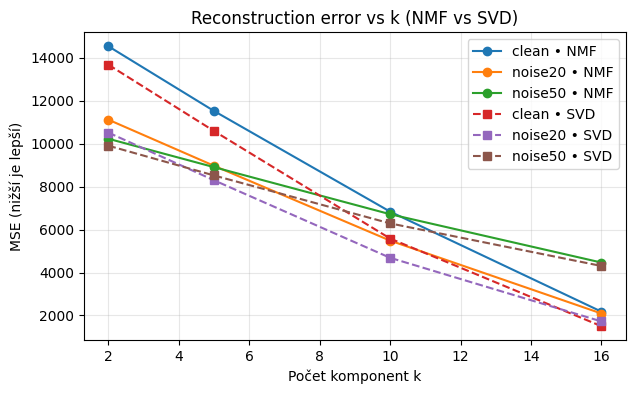

In [ ]:
ks = [2, 5, 10, 16]
nmf_results = {}
nmf_errors = {name: {} for name in datasets}

def _shift_to_nonneg(X): # Prevedeni dat do nezaporne oblasti
    m = X.min()
    offset = -m if m < 0 else 0.0
    return X + offset, offset

for name, d in datasets.items():
    X = d["X"]
    Xp, offset = _shift_to_nonneg(X)  # Offsetnute data pro NMF
    for k in ks:
        k_eff = min(k, min(Xp.shape))
        nmf = NMF(n_components=k_eff, init="nndsvda", max_iter=1000, random_state=0) # nndsvda - inicializace pro rychlejsi konvergenci
        W = nmf.fit_transform(Xp) # W - aktivace (kolik ktereho zakladniho tvaru je v kazdem obrazku)
        H = nmf.components_ # h - stavebni tvary
        X_hat = W @ H - offset  # aproximace puvodnich dat (posun zpět)
        nmf_results[(name, k_eff)] = {"W": W, "H": H, "X_hat": X_hat, "offset": offset}
        nmf_errors[name][k] = float(np.mean((X - X_hat)**2)) # MSE vůči originálním datům (necentrume)
    # report
    print(name, {k: f"{nmf_errors[name][k]:.4f}" for k in ks})

# Graf MSE vs k (NMF) + porovnání se SVD pokud je k dispozici `errors`
plt.figure(figsize=(7,4))
for name in datasets:
    plt.plot(ks, [nmf_errors[name][k] for k in ks], marker="o", label=f"{name} • NMF")
if "errors" in globals() or "errors" in locals():
    for name in datasets:
        plt.plot(ks, [errors[name][k] for k in ks], marker="s", linestyle="--", label=f"{name} • SVD")
plt.xlabel("Počet komponent k")
plt.ylabel("MSE (nižší je lepší)")
plt.title("Reconstruction error vs k (NMF vs SVD)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

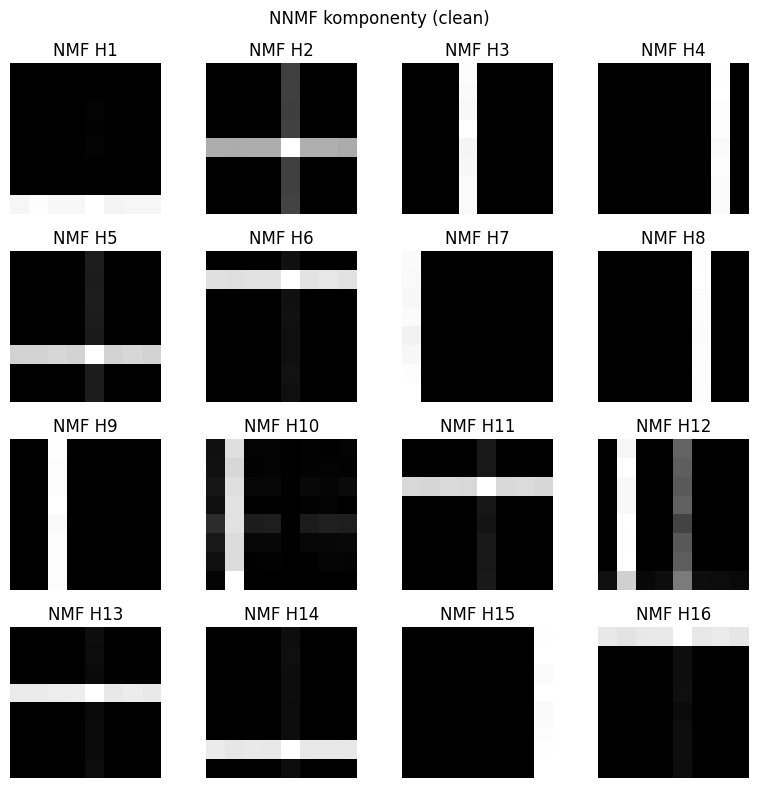

In [17]:
# NNMF komponenty (H) pro clean, k=16
name = "clean"
img_shape = datasets[name]["img_shape"]
k_show = 16
H = nmf_results[(name, min(k_show, min(datasets[name]["X"].shape)))]["H"]

k = min(k_show, H.shape[0])
rows = int(np.ceil(k/4))
fig, axes = plt.subplots(rows, 4, figsize=(8, 2*rows))
axes = np.atleast_2d(axes).ravel()
for i in range(k):
    axes[i].imshow(H[i].reshape(img_shape), cmap="gray")
    axes[i].set_title(f"NMF H{i+1}")
    axes[i].axis("off")
for j in range(k, len(axes)):
    axes[j].axis("off")
fig.suptitle("NNMF komponenty (clean)")
plt.tight_layout()
plt.show()

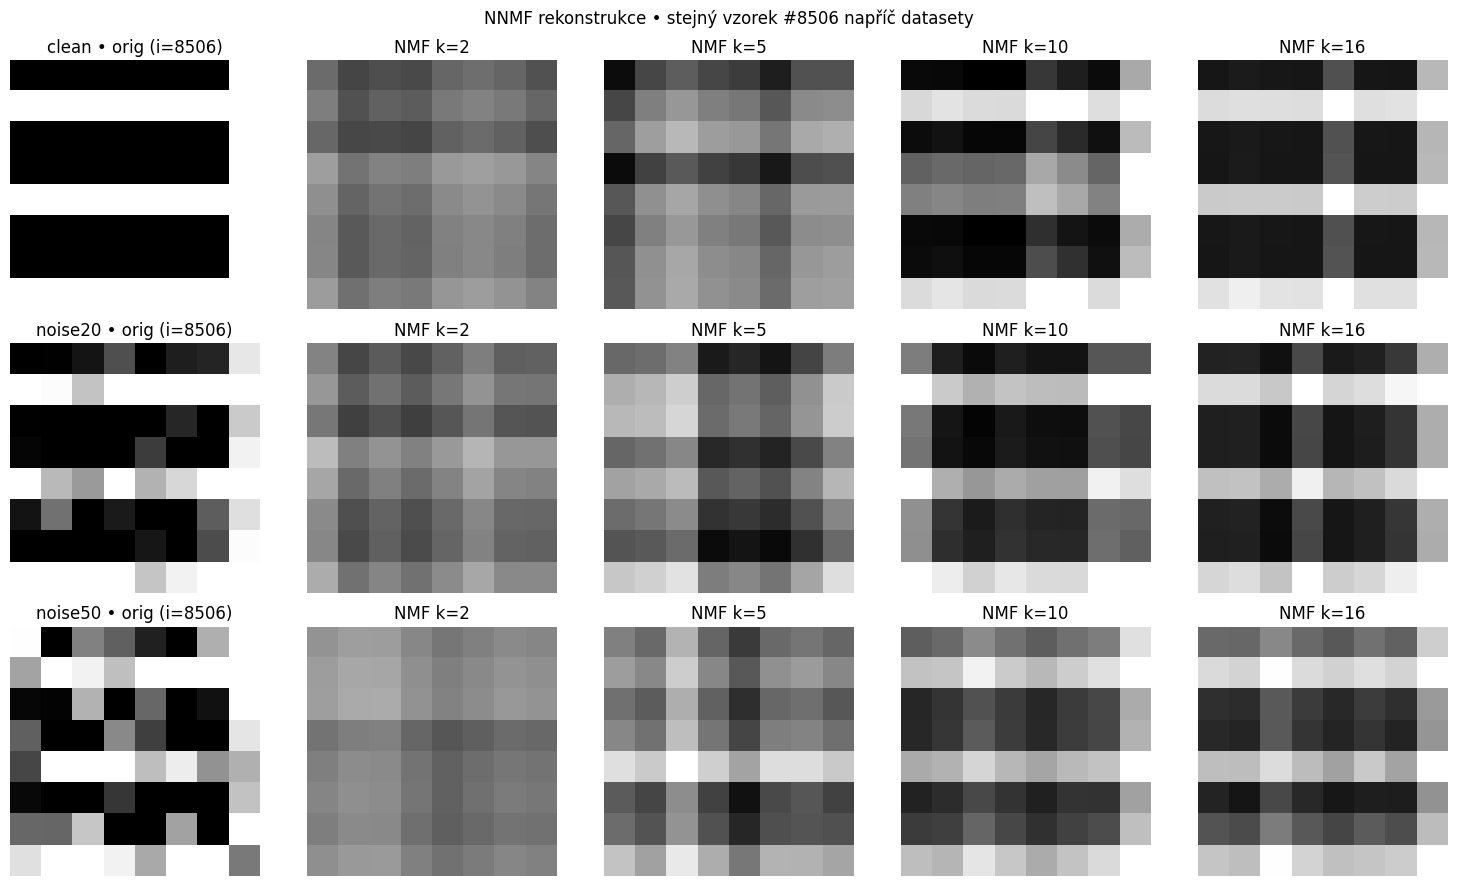

In [18]:
# Vizualizace: stejný vzorek napříč datasety, NNMF rekonstrukce
rng = np.random.default_rng(0)
ks = [2, 5, 10, 16]
names = list(datasets.keys())

min_n = min(datasets[n]["X"].shape[0] for n in names)
i = int(rng.integers(0, min_n))

rows, cols = len(names), 1 + len(ks)
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
for r, name in enumerate(names):
    d = datasets[name]
    X = d["X"]
    img_shape = d["img_shape"]
    vmin, vmax = X.min(), X.max()

    axes[r, 0].imshow(X[i].reshape(img_shape), cmap="gray", vmin=vmin, vmax=vmax)
    axes[r, 0].set_title(f"{name} • orig (i={i})")
    axes[r, 0].axis("off")

    for c, k in enumerate(ks, start=1):
        res = nmf_results.get((name, min(k, min(X.shape))))
        if res is None:
            axes[r, c].axis("off")
            continue
        X_hat = res["X_hat"]
        axes[r, c].imshow(X_hat[i].reshape(img_shape), cmap="gray", vmin=vmin, vmax=vmax)
        axes[r, c].set_title(f"NMF k={k}")
        axes[r, c].axis("off")

plt.suptitle(f"NNMF rekonstrukce • stejný vzorek #{i} napříč datasety")
plt.tight_layout()
plt.show()

## Exercise 4: MNIST Dataset - SVD Analysis and Visualization

**Task:** Apply SVD decomposition to MNIST dataset and visualize in vector space.

- Apply SVD decomposition to MNIST data
- Analyze singular values and cumulative explained variance
- Visualize MNIST data in 2D using first two SVD components
- Color points by digit labels
- Try different component combinations (e.g., components 2 and 3)


MNIST shapes: (60000, 784) (60000,)


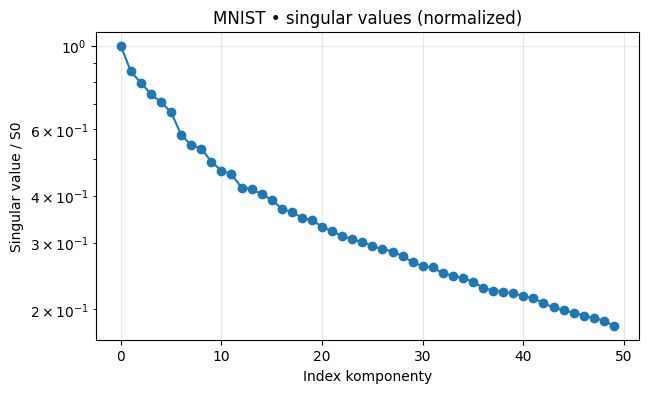

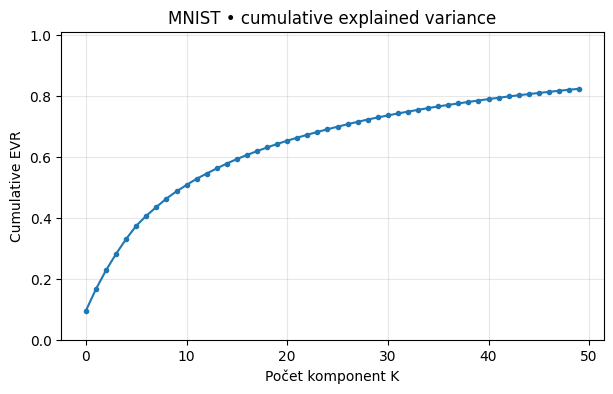

In [ ]:
def load_mnist_csv(base_dir: str):
    base = Path(base_dir)
    X = pd.read_csv(base / "mnist.csv", header=None).values.astype(np.float32)
    y = pd.read_csv(base / "mnist_labels.csv", header=None).values.ravel().astype(int)
    # škálování do <0,1>
    if X.max() > 1.0:
        X = X / 255.0
    side = int(np.sqrt(X.shape[1]))
    img_shape = (side, side) if side * side == X.shape[1] else None
    return X, y, img_shape

# X_mnist - matrice dat
# Y_mnist - vektory tříd (0-9)
# mnist_img_shape - tvar obrazku (28x28)
X_mnist, y_mnist, mnist_img_shape = load_mnist_csv("datasets/ml_05/mnist_dataset")
print("MNIST shapes:", X_mnist.shape, y_mnist.shape)

# Vycentrovaná data
Xc_mnist = X_mnist - X_mnist.mean(axis=0, keepdims=True)

# vezmeme top K komponent (rychlé a paměťově úsporné)
K = min(150, min(Xc_mnist.shape) - 1)
tsvd_mnist = TruncatedSVD(n_components=K, random_state=0)
Z_mnist = tsvd_mnist.fit_transform(Xc_mnist)   # Z ~ UΣ
S_mnist = tsvd_mnist.singular_values_
EVR_mnist = tsvd_mnist.explained_variance_ratio_
Vt_mnist = tsvd_mnist.components_

# Spektrum (normalizované) a EVR - napovi rozumne K
plt.figure(figsize=(7,4))
plt.semilogy(S_mnist / S_mnist[0], marker='o')
plt.title("MNIST • singular values (normalized)")
plt.xlabel("Index komponenty")
plt.ylabel("Singular value / S0")
plt.grid(True, alpha=0.3)
plt.show()

# Cumulative EVR - napovi rozumne K (90 - 95% variance)
plt.figure(figsize=(7,4))
plt.plot(np.cumsum(EVR_mnist), marker='.')
plt.title("MNIST • cumulative explained variance")
plt.xlabel("Počet komponent K")
plt.ylabel("Cumulative EVR")
plt.ylim(0, 1.01); plt.grid(True, alpha=0.3)
plt.show()

# Uložíme do dictu pro pozdější použití
mnist = {
    "X": X_mnist, "y": y_mnist, "Xc": Xc_mnist,
    "Z": Z_mnist, "S": S_mnist, "EVR": EVR_mnist,
    "Vt": Vt_mnist, "img_shape": mnist_img_shape
}

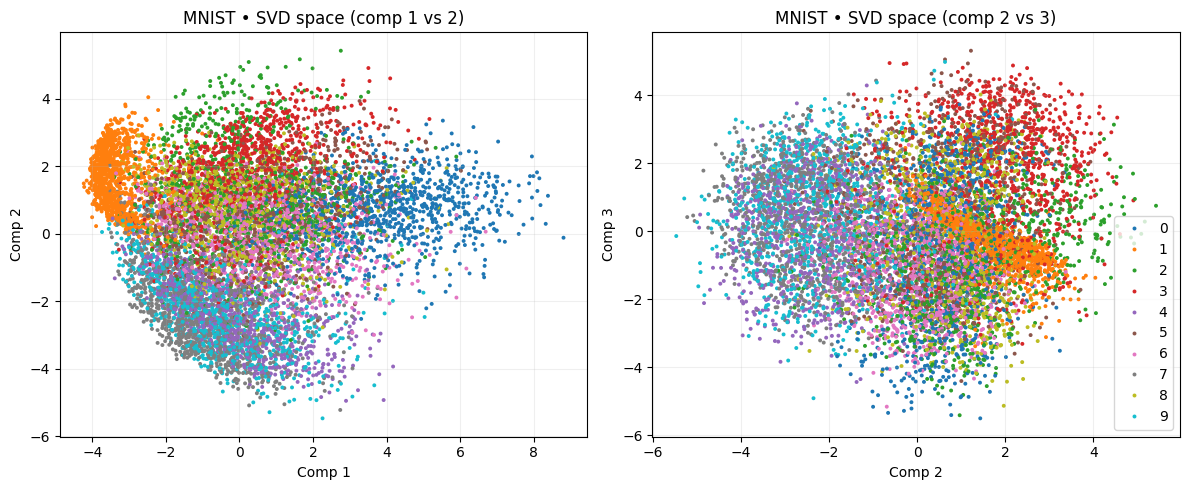

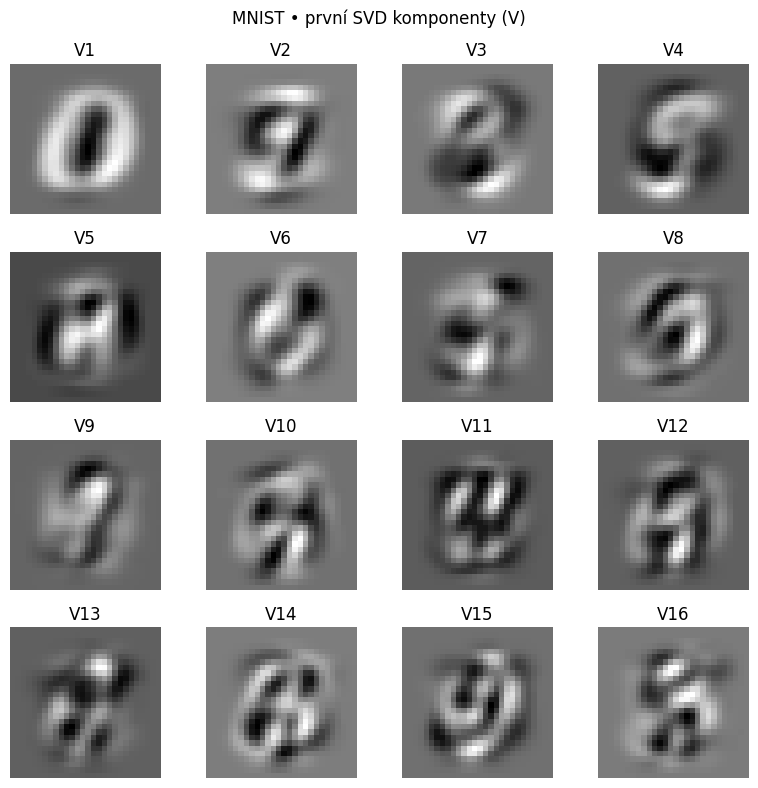

In [22]:
# ...existing code...
# 2D projekce MNIST v prostoru SVD komponent
Z = mnist["Z"]; y = mnist["y"]

# subsample pro rychlý scatter (např. 10k bodů)
max_points = 10000
n = Z.shape[0]
idx = np.arange(n)
if n > max_points:
    rng = np.random.default_rng(0)
    idx = rng.choice(n, size=max_points, replace=False)

palette = sns.color_palette("tab10", 10)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
# 1–2 komponenta
sns.scatterplot(x=Z[idx, 0], y=Z[idx, 1], hue=y[idx], palette=palette, s=8, linewidth=0, ax=axes[0], legend=False)
axes[0].set_title("MNIST • SVD space (comp 1 vs 2)")
axes[0].set_xlabel("Comp 1"); axes[0].set_ylabel("Comp 2"); axes[0].grid(True, alpha=0.2)

# 2–3 komponenta
sns.scatterplot(x=Z[idx, 1], y=Z[idx, 2], hue=y[idx], palette=palette, s=8, linewidth=0, ax=axes[1], legend=True)
axes[1].set_title("MNIST • SVD space (comp 2 vs 3)")
axes[1].set_xlabel("Comp 2"); axes[1].set_ylabel("Comp 3"); axes[1].grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

# Volitelné: první základní vzory (V) jako obrázky
if mnist["img_shape"] is not None:
    k = min(16, mnist["Vt"].shape[0])
    rows = int(np.ceil(k/4))
    fig, axes = plt.subplots(rows, 4, figsize=(8, 2*rows))
    axes = np.atleast_2d(axes).ravel()
    for i in range(k):
        axes[i].imshow(mnist["Vt"][i].reshape(mnist["img_shape"]), cmap="gray")
        axes[i].set_title(f"V{i+1}")
        axes[i].axis("off")
    for j in range(k, len(axes)):
        axes[j].axis("off")
    fig.suptitle("MNIST • první SVD komponenty (V)")
    plt.tight_layout()
    plt.show()
# ...existing code...

## Exercise 5: PCA and t-SNE Visualization of MNIST Dataset

**Task:** Apply PCA and t-SNE for dimensionality reduction and visualization of MNIST.

- Apply PCA to MNIST dataset
- Visualize MNIST data in 2D PCA space
- Apply t-SNE for non-linear dimensionality reduction
- Compare SVD, PCA, and t-SNE visualizations
- Color all visualizations by digit labels

